Note: Data contains linestrings. Not sure how to convert them to polygons or h3 cells.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import keplergl
#from keplergl import KeplerGL
import matplotlib as plt
import plotly.express as px
import h3
import shapely
from geopandas import GeoDataFrame,GeoSeries
import folium
import matplotlib
%matplotlib inline

/Users/rakeenahmed/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#reading in data
speed_limits = gpd.read_file('posted_speed_limits.geojson')

In [3]:
#convert column names to lowercase
speed_limits.columns = [s.strip().lower() for s in speed_limits.columns]

In [4]:
speed_limits.columns

Index(['fid', 'geo_id', 'objectid', 'create_id', 'address_l', 'address_r',
       'lf_name', 'oe_flag_l', 'oe_flag_r', 'fnode', 'tnode', 'lfn_id',
       'juris_code', 'districtco', 'str_name', 'str_type', 'str_dir',
       'mar13rc_10', 'mar13rc_11', 'comment', 'posted_spe', 'len_km',
       'geometry'],
      dtype='object')

In [5]:
#dropping unneccessary columns

#specifying columns to keep
cols_to_keep = ['lf_name','mar13rc_11','posted_spe','geometry']

#dropping columns
speed_limits = speed_limits[cols_to_keep]

In [6]:
speed_limits.isnull().sum()

lf_name       0
mar13rc_11    0
posted_spe    0
geometry      1
dtype: int64

In [8]:
speed_limits.head()

,lf_name,mar13rc_11,posted_spe,geometry
0,ROGERS RD,Minor Arterial,40,"LINESTRING (-79.46436 43.68254, -79.46542 43.6..."
1,ROGERS RD,Minor Arterial,40,"LINESTRING (-79.46328 43.68278, -79.46436 43.6..."
2,ROSETHORN AVE,Local,50,"LINESTRING (-79.46375 43.68108, -79.46436 43.6..."
3,SILVERTHORN AVE,Collector,50,"LINESTRING (-79.46267 43.68132, -79.46328 43.6..."
4,BLACKTHORN AVE,Local,40,"LINESTRING (-79.46183 43.68211, -79.46216 43.6..."


In [9]:
type(speed_limits)

geopandas.geodataframe.GeoDataFrame

In [10]:
#dropping speed limits that do not have a value for the geometry column
speed_limits = speed_limits.dropna()

In [11]:
speed_limits.head()

,lf_name,mar13rc_11,posted_spe,geometry
0,ROGERS RD,Minor Arterial,40,"LINESTRING (-79.46436 43.68254, -79.46542 43.6..."
1,ROGERS RD,Minor Arterial,40,"LINESTRING (-79.46328 43.68278, -79.46436 43.6..."
2,ROSETHORN AVE,Local,50,"LINESTRING (-79.46375 43.68108, -79.46436 43.6..."
3,SILVERTHORN AVE,Collector,50,"LINESTRING (-79.46267 43.68132, -79.46328 43.6..."
4,BLACKTHORN AVE,Local,40,"LINESTRING (-79.46183 43.68211, -79.46216 43.6..."


In [9]:
speed_limits.shape

(58956, 4)

In [10]:
speed_limits.posted_spe.describe()

count     58956.000000
mean         54.034890
std        1276.070414
min           0.000000
25%           1.000000
50%          40.000000
75%          50.000000
max      304050.000000
Name: posted_spe, dtype: float64

Note: There are some unreasonable speed limits in the dataset that will have to be cleaned.

### Cleaning Speed Limits

In [11]:
#drop rows with unreasonable speed limits that do not make sense e.g. speed limit = 3000
#speed_limits = speed_limits[(speed_limits.posted_spe > 10) & (speed_limits.posted_spe < 200)]

In [13]:
#looking at the roads that have posted speed limits of over 200
#looks like mostly local roads so we can replace with median speed limit
#speed_limits.loc[(speed_limits.posted_spe > 200)].explore()

In [13]:
#replacing speed limits > 200 with speed limit = 50
speed_limits.loc[(speed_limits.posted_spe > 200), 'posted_spe'] = 50

In [17]:
#looking at speed limits where limit < 10
#speed_limits.loc[(speed_limits.posted_spe < 10)].explore()

In [14]:
#different types of roads but mostly local roads
#replace with median speed limit
speed_limits.loc[(speed_limits.posted_spe < 10), 'posted_spe'] = 40

In [15]:
#checking summary statistics of speed limits again
speed_limits.posted_spe.describe()

count    58956.000000
mean        44.576973
std         11.272787
min         20.000000
25%         40.000000
50%         40.000000
75%         50.000000
max        100.000000
Name: posted_spe, dtype: float64

array([[<AxesSubplot:title={'center':'posted_spe'}>]], dtype=object)

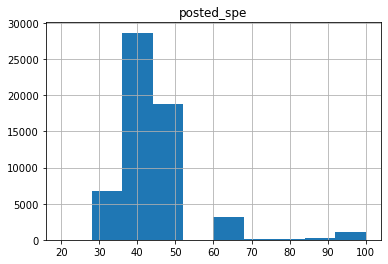

In [16]:
speed_limits.hist()

In [18]:
#rename columns
speed_limits.rename(columns={'posted_spe':'speed_limit','lf_name':'road_name','mar13rc_11':'road_class'},inplace=True)

In [19]:
speed_limits.head()

,road_name,road_class,speed_limit,geometry
0,ROGERS RD,Minor Arterial,40,"LINESTRING (-79.46436 43.68254, -79.46542 43.6..."
1,ROGERS RD,Minor Arterial,40,"LINESTRING (-79.46328 43.68278, -79.46436 43.6..."
2,ROSETHORN AVE,Local,50,"LINESTRING (-79.46375 43.68108, -79.46436 43.6..."
3,SILVERTHORN AVE,Collector,50,"LINESTRING (-79.46267 43.68132, -79.46328 43.6..."
4,BLACKTHORN AVE,Local,40,"LINESTRING (-79.46183 43.68211, -79.46216 43.6..."


In [22]:
#extracting latitude and longitude values from the linestring centroids
#speed_limits['latitude'] = speed_limits.apply(lambda x: x.geometry.centroid.coords[0][1], axis=1)
#speed_limits['longitude'] = speed_limits.apply(lambda x: x.geometry.centroid.coords[0][0], axis=1)

In [22]:
#speed_limits.explore()

In [24]:
#combining latitude and longitudes to form coordinates column
#speed_limits['coordinates'] = speed_limits.apply(lambda x: (x.latitude, x.longitude), axis=1)

#create hex cells for bike lanes

#create coordinate column
#pedestrian_crossover_exploded['coordinates'] = pedestrian_crossover_exploded['latitude'].astype('str') + ',' + pedestrian_crossover_exploded['longitude'].astype('str')

#then we define the function to get h3 hex cells from coordinates data
#def get_hex_cell(coordinates):
    #a = float(coordinates.split(',')[0])
    #b = float(coordinates.split(',')[1])
    a = coordinates[0]
    b = coordinates[1]
    return h3.latlng_to_cell(a,b,res=10)

#finally, create a new column for hex cells by applying the function on coordinates column
#speed_limits['hex_cell'] = speed_limits['coordinates'].apply(get_hex_cell)

IndentationError: unexpected indent (3795545862.py, line 13)

In [23]:
speed_limits.head()

,road_name,road_class,speed_limit,geometry
0,ROGERS RD,Minor Arterial,40,"LINESTRING (-79.46436 43.68254, -79.46542 43.6..."
1,ROGERS RD,Minor Arterial,40,"LINESTRING (-79.46328 43.68278, -79.46436 43.6..."
2,ROSETHORN AVE,Local,50,"LINESTRING (-79.46375 43.68108, -79.46436 43.6..."
3,SILVERTHORN AVE,Collector,50,"LINESTRING (-79.46267 43.68132, -79.46328 43.6..."
4,BLACKTHORN AVE,Local,40,"LINESTRING (-79.46183 43.68211, -79.46216 43.6..."


In [24]:
type(speed_limits)

geopandas.geodataframe.GeoDataFrame

In [28]:
#saving file as geojson
speed_limits.to_file('speed_limits_processed.geojson',driver='GeoJSON')